In [35]:
#| include: false

%load_ext autoreload
%autoreload 2
import torch
from matplotlib import pyplot as plt
import numpy as np
from sklearn.datasets import load_sample_images
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Abstract

In this blog post we will be investigating overfitting, overparameterization, and the double descent phenomenon. We will be using a Linear Regression model with mean-squared error loss, optimized to allow for overparamaterization. This means that the number of features will be allowed to be larger than the number of observations. We will begin by creating the model and testing it on simple datasets with n > p before moving to more complicated image data. For these images, we will manually corrupt them by removing pixels and using this to train and test the model. Here we will see how the model performs with different numbers of features up past the point where p = n to observe the double descent phenomenon.

The following code helps with this by allowing us to create feature maps with different activation functions and varying numbers of features. We will use this to test our model on data with different numbers of features.

In [4]:
def sig(x): 
    return 1/(1+torch.exp(-x))

def square(x): 
    return x**2

class RandomFeatures:
    """
    Random sigmoidal feature map. This feature map must be "fit" before use, like this: 

    phi = RandomFeatures(n_features = 10)
    phi.fit(X_train)
    X_train_phi = phi.transform(X_train)
    X_test_phi = phi.transform(X_test)

    model.fit(X_train_phi, y_train)
    model.score(X_test_phi, y_test)

    It is important to fit the feature map once on the training set and zero times on the test set. 
    """

    def __init__(self, n_features, activation = sig):
        self.n_features = n_features
        self.u = None
        self.b = None
        self.activation = activation

    def fit(self, X):
        self.u = torch.randn((X.size()[1], self.n_features), dtype = torch.float64)
        self.b = torch.rand((self.n_features), dtype = torch.float64) 

    def transform(self, X):
        return self.activation(X @ self.u + self.b)

# Part 0
If X in an n x p matrix, then $\mathbf{X}^T \mathbf{X}$ is a p x p matrix. The rank of $\mathbf{X}^T \mathbf{X}$ is equal to the rank of X which is equal to the number of linearly independent columns of X. The rank of $\mathbf{X}^T \mathbf{X}$ is at most the minimum of n and p, so the rank of $\mathbf{X}^T \mathbf{X}$ is at most p when n > p. If the rank of X is p, then $\mathbf{X}^T \mathbf{X}$ is invertible since the matrix is p x p. If the rank of X is less than p, then $\mathbf{X}^T \mathbf{X}$ is not invertible, so when p > n $\mathbf{X}^T \mathbf{X}$ is not invertible so Equation 1 doesn't work.

# Implement Overparameterized Linear Regression
The first part involves creating the linear regression model in a way that uses mean-squared error loss and allows for p > n. We will be using the following code to create the model, inheriting the basic LinearModel and writing the loss function to use mean-squared error. We will also be creating a new optimizer to fit the function using the Moore-Penrose pseudo-inverse. This will allow us to fit the model even when p > n to avoid the problem explained above.

In [5]:
class LinearModel:

    def __init__(self):
        self.w = None 

    def score(self, X):
        """
        Compute the scores for each data point in the feature matrix X. 
        The formula for the ith entry of s is s[i] = <self.w, x[i]>. 

        If self.w currently has value None, then it is necessary to first initialize self.w to a random value. 

        ARGUMENTS: 
            X, torch.Tensor: the feature matrix. X.size() == (n, p), 
            where n is the number of data points and p is the 
            number of features. This implementation always assumes 
            that the final column of X is a constant column of 1s. 

        RETURNS: 
            s torch.Tensor: vector of scores. s.size() = (n,)
        """
        if self.w is None: 
            self.w = torch.rand((X.size()[1]))
        return torch.matmul(X, self.w)
    
class MyLinearRegression(LinearModel):

    def loss(self, X, y):
        """
        Compute the loss for each data point in the feature matrix X using the mean squared error.

        ARGUMENTS: 
            X, torch.Tensor: the feature matrix. X.size() == (n, p), 
            where n is the number of data points and p is the 
            number of features. This implementation always assumes 
            that the final column of X is a constant column of 1s. 

            y, torch.Tensor: the target vector.  y.size() = (n,). The possible labels for y are {0, 1}
        """
        scores = self.score(X)
        mse = torch.mean((scores - y) ** 2)
        return mse

    def predict(self, X):
        """
        Compute the predictions for each data point in the feature matrix X.
        For linear regression, this is just the dot product between weights and inputs.

        ARGUMENTS:
            X, torch.Tensor: the feature matrix. X.size() == (n, p)

        RETURNS:
            y_hat, torch.Tensor: vector of predicted values (n,)
        """
        return self.score(X)
    
class OverParameterizedLinearRegressionOptimizer:

    def __init__(self, model):
        self.model = model 
    
    def fit(self, X, y):
        X_pinv = torch.linalg.pinv(X)
        self.model.w = torch.matmul(X_pinv, y)

# Test Model on Simple Data
The next step is to test that this model is working. To do this we will test on a simple case where n > p. If it doesn't work in that case then it has no chance of working in the overparameterized case. We will create a simple dataset with 100 observations and use RandomFeatures to create a feature matrix of 10 features (so that n > p). We will then fit the model and plot the results.

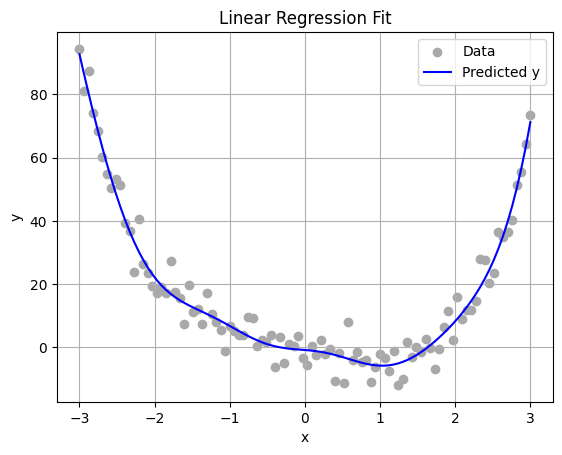

In [29]:
X = torch.tensor(np.linspace(-3, 3, 100).reshape(-1, 1), dtype = torch.float64)
y = X**4 - 4*X + torch.normal(0, 5, size=X.shape)

plt.scatter(X, y, color='darkgrey', label='Data')

phi = RandomFeatures(n_features=10)
phi.fit(X)
X_features = phi.transform(X)

LR = MyLinearRegression()
opt = OverParameterizedLinearRegressionOptimizer(LR)
opt.fit(X_features, y)

y_pred = LR.predict(X_features)

x_vals = X[:, 0]

plt.plot(x_vals, y_pred.detach(), label='Predicted y', color='blue')

plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear Regression Fit")
plt.legend()
plt.grid(True)
plt.show()

As we can see, the model did well to fit the data with n > p. This indicates that it is working as intended and we can move on to test it on more complicated datasets with more features.

# Double Descent In Image Corruption Detection
To test our function on more complicated data, we will be using a corrupted image of a flower. The following code will create the dataset and show the flower that it represents.

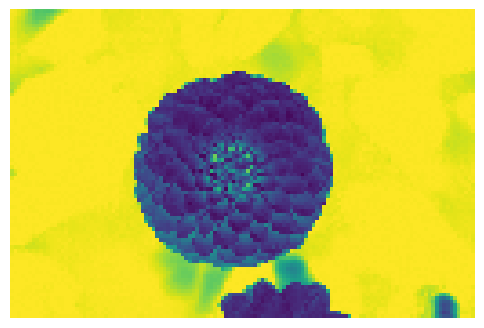

In [ ]:
dataset = load_sample_images()     
X = dataset.images[1]
X = zoom(X,.2) #decimate resolution
X = X.sum(axis = 2)
X = X.max() - X 
X = X / X.max()
flower = torch.tensor(X, dtype = torch.float64)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(flower)
off = ax.axis("off")

We want to corrupt this image by adding patches to the image. The following code does this.

In [31]:
def corrupted_image(im, mean_patches = 5): 
    n_pixels = im.size()
    num_pixels_to_corrupt = torch.round(mean_patches*torch.rand(1))
    num_added = 0

    X = im.clone()

    for _ in torch.arange(num_pixels_to_corrupt.item()): 
        
        try: 
            x = torch.randint(0, n_pixels[0], (2,))

            x = torch.randint(0, n_pixels[0], (1,))
            y = torch.randint(0, n_pixels[1], (1,))

            s = torch.randint(5, 10, (1,))
            
            patch = torch.zeros((s.item(), s.item()), dtype = torch.float64) + 0.5

            # place patch in base image X
            X[x:x+s.item(), y:y+s.item()] = patch
            num_added += 1

            
        except: 
            pass

    return X, num_added

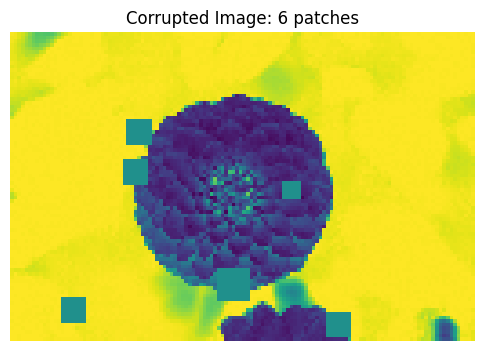

In [32]:
X, y = corrupted_image(flower, mean_patches = 50)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(X.numpy(), vmin = 0, vmax = 1)
ax.set(title = f"Corrupted Image: {y} patches")
off = plt.gca().axis("off")

Our goal is to be able to predict the number of patches on the image using just the corrupted image. To test this, we will create a dataset with the following code, made up of 200 images with varying numbers of patches. We need to flatten these matrices so that it can be inputted into the model and then we split it into a training and test set.

In [36]:
n_samples = 200

X = torch.zeros((n_samples, flower.size()[0], flower.size()[1]), dtype = torch.float64)
y = torch.zeros(n_samples, dtype = torch.float64)
for i in range(n_samples): 
    X[i], y[i] = corrupted_image(flower, mean_patches = 100)

X = X.reshape(n_samples, -1)
# X.reshape(n_samples, -1).size()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

With the data created, we can now test the model. We will be using the following code to train and test the model using increasing numbers of features past the interpolation threshold (where the number of features exceed the number of samples). We will plot the training and test mean-squared error to see how the model performs with increasing numbers of features along with the interpolation threshold.

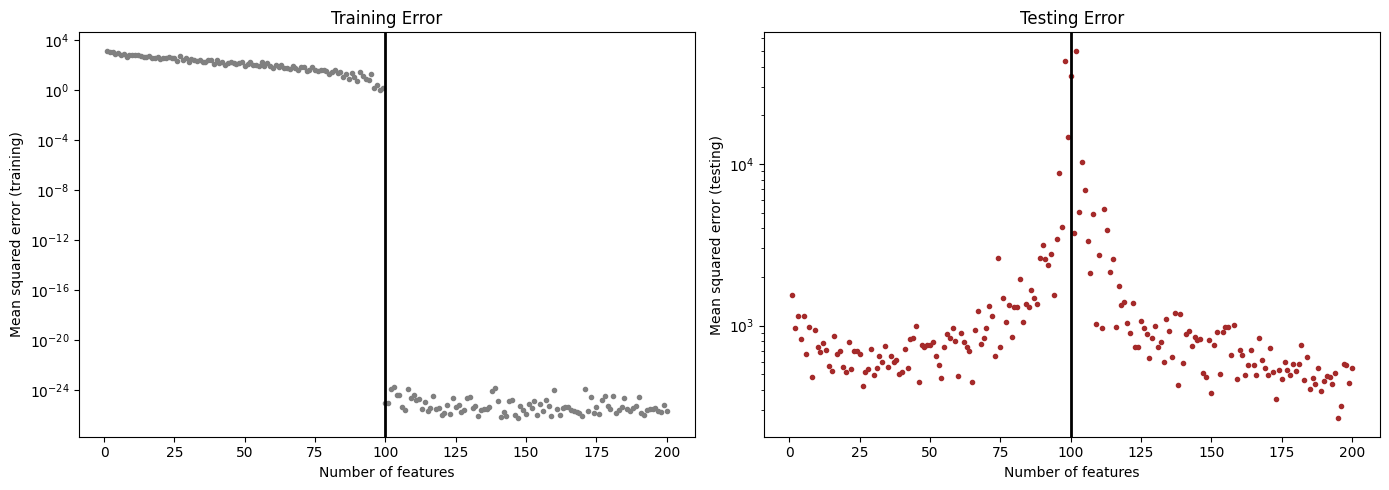

In [55]:
train_errors = []
test_errors = []
feature_range = range(1, 201)
n_train = X_train.shape[0]
interpolation_threshold = n_train

for n_features in feature_range:
    phi = RandomFeatures(n_features=n_features, activation=square)
    phi.fit(X_train)
    
    X_train_feat = phi.transform(X_train)
    X_test_feat = phi.transform(X_test)

    LR = MyLinearRegression()
    opt = OverParameterizedLinearRegressionOptimizer(LR)
    opt.fit(X_train_feat, y_train)

    y_train_pred = LR.predict(X_train_feat)
    y_test_pred = LR.predict(X_test_feat)

    train_mse = torch.mean((y_train_pred - y_train)**2).item()
    test_mse = torch.mean((y_test_pred - y_test)**2).item()

    train_errors.append(train_mse)
    test_errors.append(test_mse)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(feature_range, train_errors, '.', color='gray')
axes[0].axvline(interpolation_threshold, color='black', linewidth=2)
axes[0].set_yscale('log')
axes[0].set_xlabel('Number of features')
axes[0].set_ylabel('Mean squared error (training)')
axes[0].set_title('Training Error')

axes[1].plot(feature_range, test_errors, '.', color='brown')
axes[1].axvline(interpolation_threshold, color='black', linewidth=2)
axes[1].set_yscale('log')
axes[1].set_xlabel('Number of features')
axes[1].set_ylabel('Mean squared error (testing)')
axes[1].set_title('Testing Error')

plt.tight_layout()
plt.show()

Both plots show clear trends around the interpolation threshold with the loss for the training data becoming effectively zero after the threshold. This makes sense because after that point we can perfectly "connect the dots" and have a perfect fit. The test loss, however, shows a different trend. It starts to increase up to the interpolation threshold before decreasing afterwards. This exhibits the double descent phenomenon where the test loss decreases after the interpolation threshold. This shows that increasing the features past the interpolation threshold can actually improve the model performance. This is a counterintuitive result that shows that overparameterization can be beneficial in some cases. To demonstrate this we will find the minimum test loss and the corresponding number of features.

In [58]:
minimum_test_error = min(test_errors)
min_index = test_errors.index(minimum_test_error)
print(f"Optimal number of features: {min_index + 1}")
print(f"Minimum test error: {minimum_test_error}")


Optimal number of features: 195
Minimum test error: 267.1711725186059


As we can see, the optimal number of features for the minimum test error is past the interpolation threshold, confirming our takeaways from the graph.

# Discussion
Standard machine learning theory in the past suggested that overfitting is a bad thing that should be avoided at all costs. What we have shown here, however, is that, in some cases, interpolating the data actually overperforms models with fewer features. The fact that overparameterization can be beneficial is surprising but has large implications as we see with modern models that have billions of parameters. This is thanks in part to the double descent phenomenon allowing for overparameterization. To do this, we had to change the way our model functions to avoid the problem of non-invertable matrices when p > n. This was done by using the Moore-Penrose pseudo-inverse to allow for overparameterization. Overall, the double descent phenomenon was a significant result that had large implications for machine learning.